# example_plothmi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# import matplotlib.pyplot as plt
# import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import sunpy.map
from copy import deepcopy
import gc, os
from usr_sunpy import *

# Read data

In [2]:
path = os.path.realpath(os.curdir)
fname1 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.field.fits'
fname2 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.inclination.fits'
fname3 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.azimuth.fits'
fname4 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.disambig.fits'
print('[Path] %s' % path)

[Path] /home/lydia/codes/zly/scripts-sunpy/plothmi


In [9]:
mapb = read_sdo(fname1)
mapi = read_sdo(fname2)
mapa = read_sdo(fname3)
mapd = read_sdo(fname4)

hmi.B_720s.20150827_052400_TAI.field.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.inclination.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.azimuth.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.disambig.fits	[4096, 4096]


In [4]:
# Disambiguate
mapa.data[mapd.data > 3] += 180.

In [10]:
mapbx = deepcopy(mapb)
mapby = deepcopy(mapb)
mapbz = deepcopy(mapb)
mapbx.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.cos(np.deg2rad(mapa.data + 270.))
mapby.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.sin(np.deg2rad(mapa.data + 270.))
mapbz.data[:] = mapb.data * np.cos(np.deg2rad(mapi.data))

In [11]:
# Rotate(CCW)
order = 3  # Test: 3 is the best
print('Fixing image axes...')
mapbx = mapbx.rotate(order=order)
mapby = mapby.rotate(order=order)
mapbz = mapbz.rotate(order=order)
print('Rotation angle = %f deg (CCW)' % -mapb.meta['crota2'])

Fixing image axes...
Rotation angle = -180.013600 deg (CCW)


In [12]:
# Get the center ('crpix1', 'crpix2') - First pixel is number 1.
pcenter = ((mapbz.meta['crpix1'] - 1) * u.pix, (mapbz.meta['crpix2'] - 1) * u.pix)
center = mapbz.pixel_to_world(*pcenter)
print('[Image_center] (%.3f, %.3f)pixel = (%7.4f, %7.4f)arcsec  (lon, lat) = (%8.5f, %8.5f)deg' %
      ((mapbz.dimensions.x.value-1.)/2., (mapbz.dimensions.y.value-1.)/2.,
         mapbz.center.Tx.value, mapbz.center.Ty.value,
         mapbz.center.heliographic_stonyhurst.lon.value, mapbz.center.heliographic_stonyhurst.lat.value))
print('[ Disk_center] (%.3f, %.3f)pixel = (%7.4f, %7.4f)arcsec  (lon, lat) = (%8.5f, %8.5f)deg' %
      (pcenter[0].value, pcenter[1].value, center.Tx.value, center.Ty.value,
       center.heliographic_stonyhurst.lon.value, center.heliographic_stonyhurst.lat.value))
print('[ Observation] (lon, lat, radius) = (%g deg, %g deg, %g m)' %
      (mapbz.heliographic_longitude.value, mapbz.heliographic_latitude.value, mapbz.observer_coordinate.radius.value))

[Image_center] (2048.500, 2048.500)pixel = (-7.1497,  2.8244)arcsec  (lon, lat) = (-0.43292,  7.25845)deg
[ Disk_center] (2063.175, 2043.400)pixel = ( 0.0000,  0.0000)arcsec  (lon, lat) = ( 0.00000,  7.08900)deg
[ Observation] (lon, lat, radius) = (0 deg, 7.089 deg, 1.51197e+11 m)


In [8]:
# Release
del mapb, mapi, mapa, mapd; gc.collect();

<IPython.core.display.Javascript object>


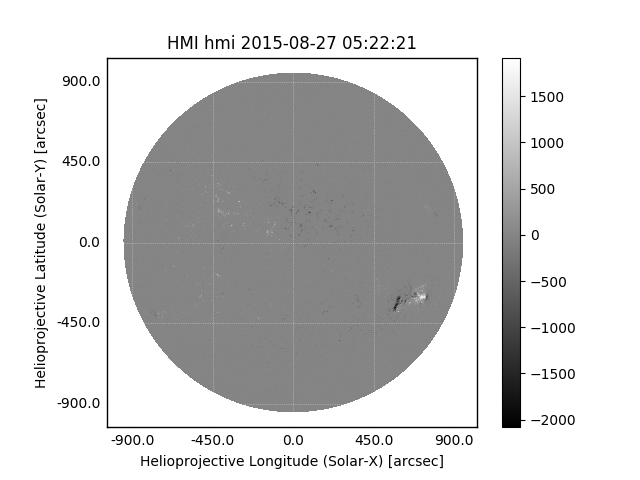

In [9]:
# A quick plot
mapbz.peek()

# Plot

<IPython.core.display.Javascript object>


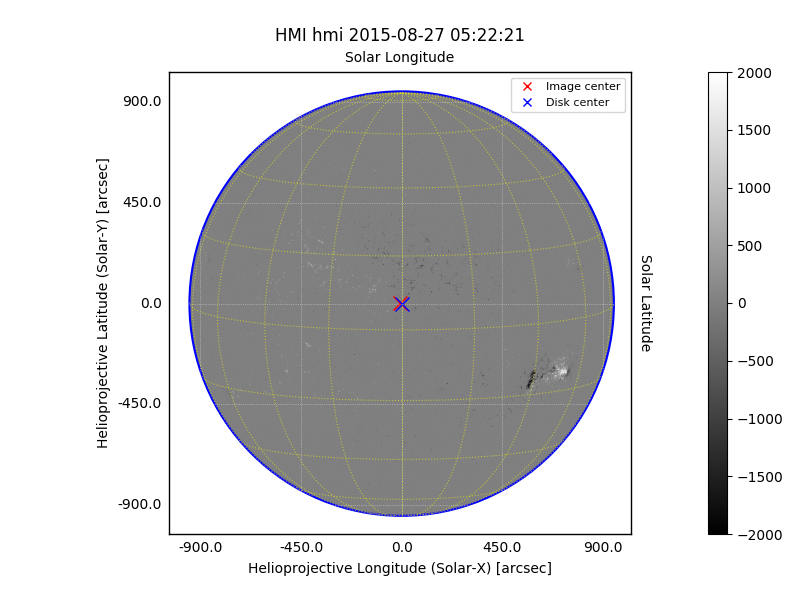

In [10]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(ax1, mapbz, grid=True)

# Properties
mapbz.draw_grid(axes=ax1, grid_spacing=20*u.deg, color='yellow', linestyle=':')
mapbz.draw_limb(axes=ax1, color='b', linewidth=1.5)
ax1.plot_coord(mapbz.center, 'rx', markersize=10, linewidth=1.5, label='Image center')
ax1.plot_coord(center, 'bx', markersize=10, linewidth=1.5, label='Disk center')
ax1.set_title(mapbz.latex_name, y=1.05);
plt.clim(-2000., 2000.)
ax1.legend(loc='upper right', fontsize=8, markerscale=0.6);
# fig1.savefig(path+'/'+'example_plothmi.png', dpi=200)

# Submap

In [13]:
xmin, xmax = (300., 800.)  # arcsec
ymin, ymax = (-500., -100.)

bl = SkyCoord(xmin*u.arcsec, ymin*u.arcsec, frame=mapbz.coordinate_frame)
tr = SkyCoord(xmax*u.arcsec, ymax*u.arcsec, frame=mapbz.coordinate_frame)
smapbx = mapbx.submap(bl, tr)
smapby = mapby.submap(bl, tr)
smapbz = mapbz.submap(bl, tr)
print('Submap: %s = %s arcsec' % (map(int, u.Quantity(smapbz.dimensions).value), [[xmin, xmax], [ymin, ymax]]))

Submap: [992, 793] = [[300.0, 800.0], [-500.0, -100.0]] arcsec


<IPython.core.display.Javascript object>


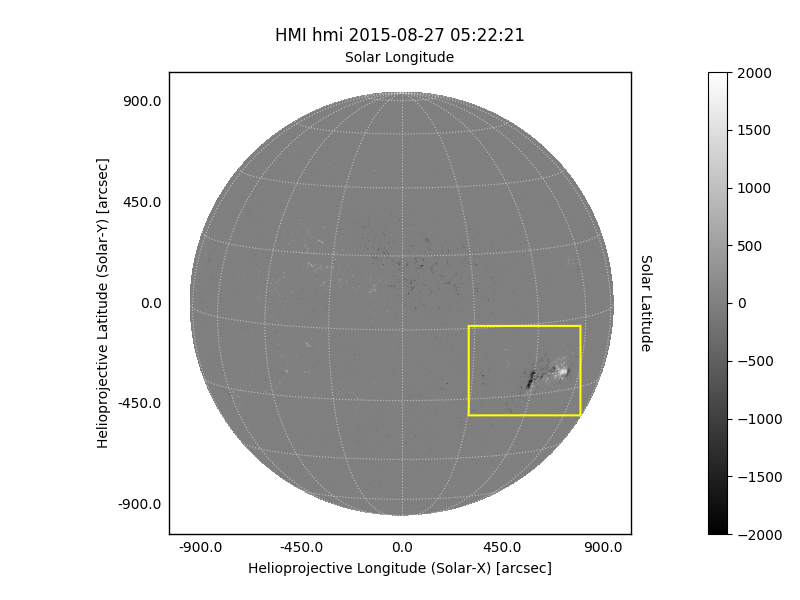

In [19]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(ax1, mapbz)

# Properties
mapbz.draw_grid(axes=ax1, grid_spacing=20*u.deg, color='w', linestyle=':')
mapbz.draw_rectangle(bl, (xmax-xmin)*u.arcsec, (ymax-ymin)*u.arcsec, axes=ax1, color='yellow', linewidth=1.5)
# ax1.set_title(mapbz.latex_name, y=1.05);
plt.clim(-2000., 2000.)
# fig1.savefig(path+'/'+'example_plothmi_2.png', dpi=200)

<IPython.core.display.Javascript object>


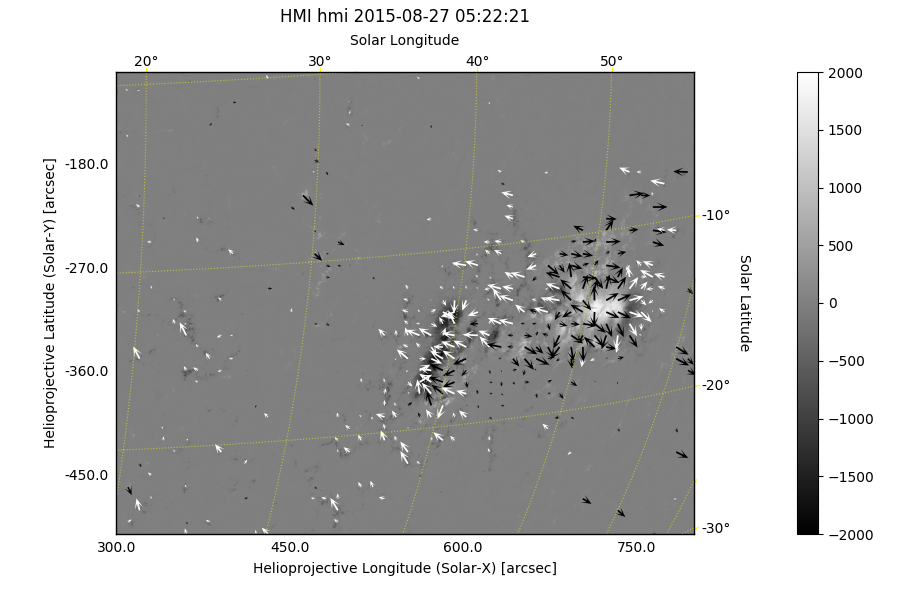

In [8]:
iskip, jskip = (20, 20)

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(ax2, smapbz)
plot_vmap(ax2, smapbx, smapby, smapbz, iskip=iskip, jskip=jskip, cmin=20., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02)

# Properties
smapbz.draw_grid(axes=ax2, grid_spacing=10*u.deg, color='yellow', linestyle=':')
ax2.set_title(mapbz.latex_name, y=1.09);
plt.subplots_adjust(right=0.8)  # Reduce the value to shift the colorbar right
im2.set_clim(-2000., 2000.)

Without disambiguation:

<IPython.core.display.Javascript object>


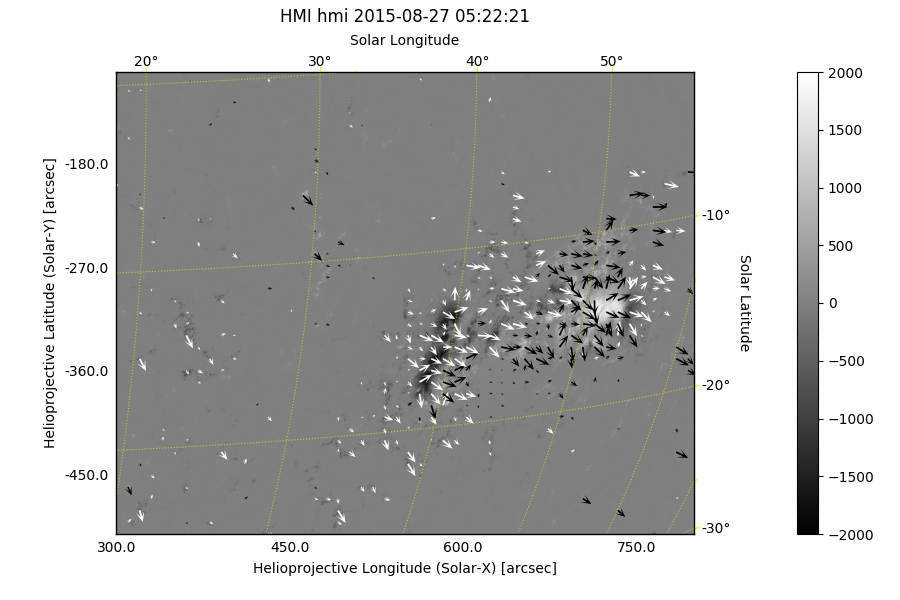

In [14]:
iskip, jskip = (20, 20)

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(ax2, smapbz)
plot_vmap(ax2, smapbx, smapby, smapbz, iskip=iskip, jskip=jskip, cmin=20., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02)

# Properties
smapbz.draw_grid(axes=ax2, grid_spacing=10*u.deg, color='yellow', linestyle=':')
ax2.set_title(mapbz.latex_name, y=1.09);
plt.subplots_adjust(right=0.8)  # Reduce the value to shift the colorbar right
im2.set_clim(-2000., 2000.)